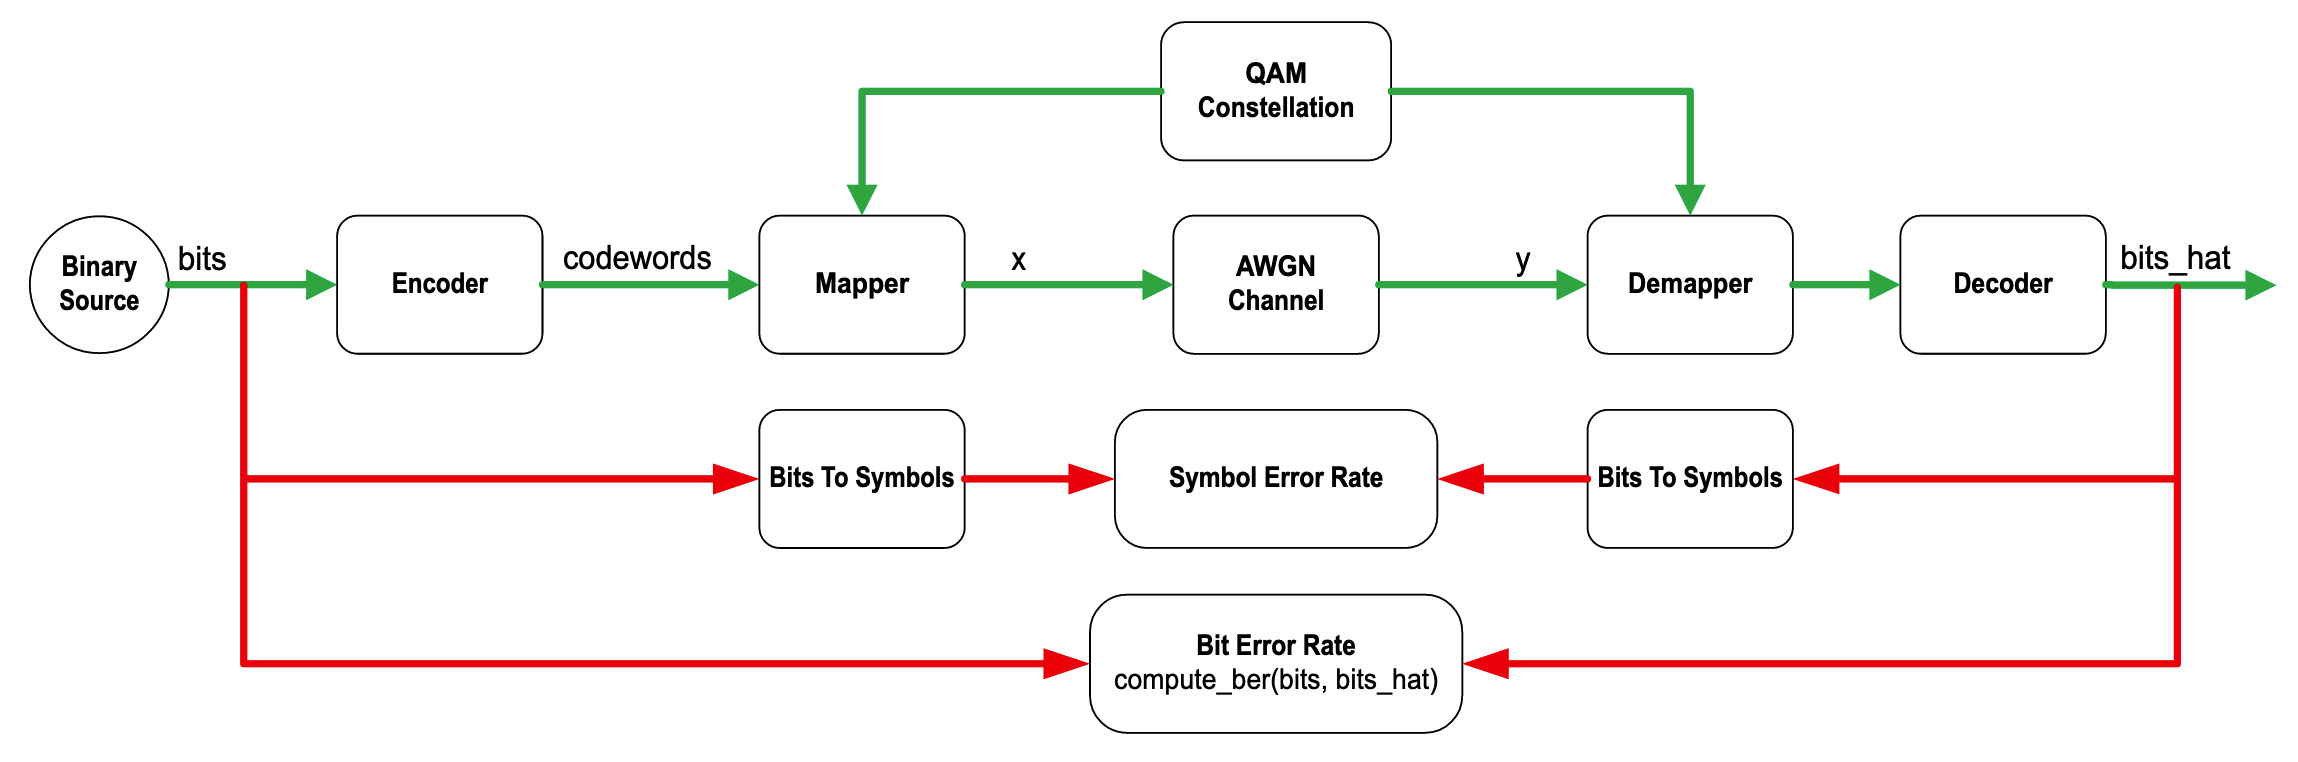

## Wrong

bers_UncodedSystem:
 [0.36129688 0.34499805 0.32218359 0.30050586 0.27742969 0.25255469
 0.22691016 0.20162305 0.1766582  0.15327539 0.12907617 0.10629297
 0.08547656 0.06449805 0.04615625 0.03083594 0.01878906 0.00976758
 0.004375   0.00188867]
bers_CodedSystem:
 [0.42821094 0.41884961 0.40782031 0.3919707  0.37808789 0.36105859
 0.34172266 0.32079687 0.29475391 0.26962109 0.2371875  0.19601953
 0.11762891 0.02002148 0.00076953 0.         0.         0.
 0.         0.        ]
sers_UnodedSystem:
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
sers_CodedSystem:
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


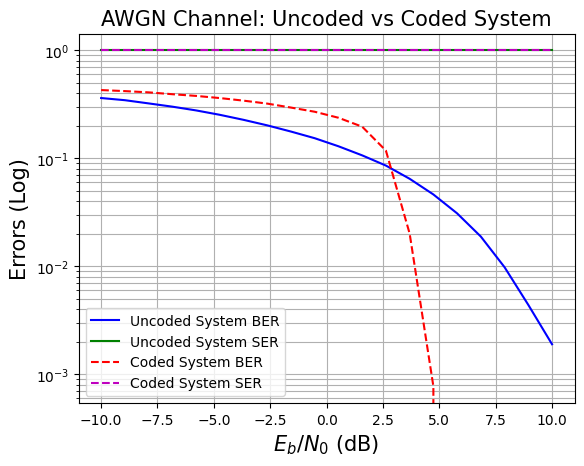

In [96]:
# Imports & Basics

# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

# For plotting
%matplotlib inline
# also try %matplotlib widget

import matplotlib.pyplot as plt

# for performance measurements
import time

# For the implementation of the Keras models
from tensorflow.keras import Model

from sionna.utils.misc import hard_decisions
from sionna.utils.metrics import compute_ber, compute_ser

CODERATE = 0.5
n = 512
k = int(n*CODERATE)

NUM_BITS_PER_SYMBOL = 4 # QPSK
BLOCK_LENGTH = k
BATCH_SIZE = 2000 # How many examples are processed by Sionna in parallel
EBN0_DB_MIN = -10.0 # Minimum value of Eb/N0 [dB] for simulations
EBN0_DB_MAX = 10.0 # Maximum value of Eb/N0 [dB] for simulations

# Constellation
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)
#constellation.show(figsize=(7,7));

# Mapper and Demapper
mapper = sn.mapping.Mapper(constellation=constellation)
# The demapper uses the same constellation object as the mapper
demapper = sn.mapping.Demapper("app", constellation=constellation)

# Binary source
binary_source = sn.utils.BinarySource()

# AWGN channel
awgn_channel = sn.channel.AWGN()

# LDPC Encoder
LDPC_encoder = sn.fec.ldpc.LDPC5GEncoder(k, n)

# LDPC Decoder
LDPC_decoder = sn.fec.ldpc.LDPC5GDecoder(LDPC_encoder, hard_out=True)

snrs = []
bers_UncodedSystem = []
sers_UncodedSystem = []
bers_CodedSystem = []
sers_CodedSystem = []

bits = binary_source([BATCH_SIZE,BLOCK_LENGTH])

for EBN0_DB in np.linspace(EBN0_DB_MIN,EBN0_DB_MAX,20):

    snrs += [EBN0_DB]

    no_UncodedSystem = sn.utils.ebnodb2no(ebno_db=EBN0_DB,
                            num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                            coderate=1.0) # Coderate set to 1 as we do uncoded transmission here
    
    no_CodedSystem = sn.utils.ebnodb2no(ebno_db=EBN0_DB,
                            num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                            coderate=CODERATE) # Coderate set to 1 as we do uncoded transmission here

    x_UncodedSystem = mapper(bits)

    y_UncodedSystem = awgn_channel([x_UncodedSystem, no_UncodedSystem])

    llr_UncodedSystem = demapper([y_UncodedSystem, no_UncodedSystem])

    bits_hat_UncodedSystem = hard_decisions(llr_UncodedSystem)

    ber_UncodedSystem = compute_ber(bits, bits_hat_UncodedSystem)

    ser_UncodedSystem = compute_ser(x_UncodedSystem, y_UncodedSystem)

    bers_UncodedSystem += [ber_UncodedSystem]
    sers_UncodedSystem += [ser_UncodedSystem]


    codewords = LDPC_encoder(bits)

    x_CodedSystem = mapper(codewords)
	
    y_CodedSystem = awgn_channel([x_CodedSystem, no_CodedSystem])
	    
    llr_CodedSystem = demapper([y_CodedSystem, no_CodedSystem])
		
    bits_hat_CodedSystem = LDPC_decoder(llr_CodedSystem)
		    
    ber_CodedSystem = compute_ber(bits, bits_hat_CodedSystem)
			
    ser_CodedSystem = compute_ser(x_CodedSystem, y_CodedSystem)

    bers_CodedSystem += [ber_CodedSystem]
    sers_CodedSystem += [ser_CodedSystem]

print('bers_UncodedSystem:\n',np.transpose(bers_UncodedSystem))
print('bers_CodedSystem:\n',np.transpose(bers_CodedSystem))
print('sers_UnodedSystem:\n',np.transpose(sers_UncodedSystem))
print('sers_CodedSystem:\n',np.transpose(sers_CodedSystem))
title = "AWGN Channel: Uncoded vs Coded System"
xlabel = "$E_b/N_0$ (dB)"
ylabel = "Errors (Log)"
plt.title(title, fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel(ylabel, fontsize=15)
plt.grid(which="both")
plt.semilogy(snrs, bers_UncodedSystem, 'b', label='Uncoded System BER')
plt.semilogy(snrs, sers_UncodedSystem, 'g', label='Uncoded System SER')
plt.semilogy(snrs, bers_CodedSystem, 'r--', label='Coded System BER')
plt.semilogy(snrs, sers_CodedSystem, 'm--', label='Coded System SER')
plt.legend(loc='lower left', fontsize=10)
plt.show()

## Uncoding: BER vs SER

bers_UncodedSystem:
 [0.36427307 0.34317017 0.32324409 0.30095673 0.27759361 0.25246429
 0.22677612 0.20185089 0.17788696 0.15242767 0.12961769 0.1071701
 0.08530617 0.06432533 0.04589081 0.03075218 0.01859474 0.01022339
 0.0046711  0.00170326]
sers_UnodedSystem:
 [0.8396 0.8176 0.7957 0.7695 0.7401 0.706  0.6643 0.6184 0.5699 0.5099
 0.4483 0.3813 0.312  0.241  0.1747 0.1193 0.073  0.0405 0.0186 0.0068]


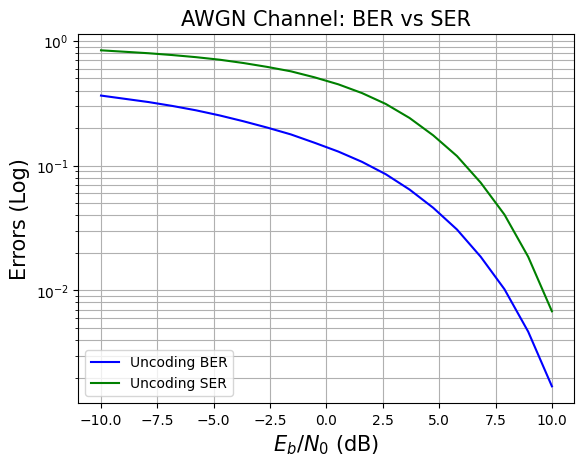

In [110]:
# Imports & Basics

# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

# For plotting
%matplotlib inline
# also try %matplotlib widget

import matplotlib.pyplot as plt

# for performance measurements
import time

# For the implementation of the Keras models
from tensorflow.keras import Model

from sionna.utils.misc import hard_decisions
from sionna.utils.metrics import compute_ber, compute_ser

CODERATE = 0.5
n = 512
k = int(n*CODERATE)

NUM_BITS_PER_SYMBOL = 4 # QPSK
BLOCK_LENGTH = k
BATCH_SIZE = 2048 # How many examples are processed by Sionna in parallel
EBN0_DB_MIN = -10.0 # Minimum value of Eb/N0 [dB] for simulations
EBN0_DB_MAX = 10.0 # Maximum value of Eb/N0 [dB] for simulations

# Constellation
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)
#constellation.show(figsize=(7,7));

# Mapper and Demapper
mapper = sn.mapping.Mapper(constellation=constellation)
# The demapper uses the same constellation object as the mapper
demapper = sn.mapping.Demapper("app", constellation=constellation)

# Binary source
binary_source = sn.utils.BinarySource()

# AWGN channel
awgn_channel = sn.channel.AWGN()

# LDPC Encoder
LDPC_encoder = sn.fec.ldpc.LDPC5GEncoder(k, n)

# LDPC Decoder
LDPC_decoder = sn.fec.ldpc.LDPC5GDecoder(LDPC_encoder, hard_out=True)

snrs = []
bers_UncodedSystem = []
sers_UncodedSystem = []
# bers_CodedSystem = []
# sers_CodedSystem = []

bits = binary_source([BATCH_SIZE,BLOCK_LENGTH])
# print('bits.shape =\n',bits.shape)
# print('bits = \n',bits)

Tx_Symbols = np.reshape(bits, (BATCH_SIZE, (BLOCK_LENGTH//NUM_BITS_PER_SYMBOL), NUM_BITS_PER_SYMBOL))
# print('Tx_Symbols.shape =\n',Tx_Symbols.shape)
# print('Tx_Symbols = \n',Tx_Symbols)

num_symbols = BATCH_SIZE*(BLOCK_LENGTH/NUM_BITS_PER_SYMBOL)
# print('num_symbols =\n',num_symbols)

for EBN0_DB in np.linspace(EBN0_DB_MIN,EBN0_DB_MAX,20):

    snrs += [EBN0_DB]

    no_UncodedSystem = sn.utils.ebnodb2no(ebno_db=EBN0_DB,
                            num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                            coderate=1.0) # Coderate set to 1 as we do uncoded transmission here

    no_CodedSystem = sn.utils.ebnodb2no(ebno_db=EBN0_DB,
                            num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                            coderate=CODERATE) # Coderate set to 1 as we do uncoded transmission here

    x_UncodedSystem = mapper(bits)

    y_UncodedSystem = awgn_channel([x_UncodedSystem, no_UncodedSystem])

    llr_UncodedSystem = demapper([y_UncodedSystem, no_UncodedSystem])

    bits_hat_UncodedSystem = hard_decisions(llr_UncodedSystem)

    Rx_Symbols_UncodedSystem = np.reshape(bits_hat_UncodedSystem, (BATCH_SIZE, (BLOCK_LENGTH//NUM_BITS_PER_SYMBOL), NUM_BITS_PER_SYMBOL)) # type: ignore
    # print('Rx_Symbols.shape =\n',Rx_Symbols_UncodedSystem.shape)
    # print('Rx_Symbols = \n',Rx_Symbols_UncodedSystem)

    ber_UncodedSystem = compute_ber(bits, bits_hat_UncodedSystem)

    error_array_UncodedSystem = np.all(Tx_Symbols == Rx_Symbols_UncodedSystem, axis=2)
    # print('compare =\n',compare)

    error_array_UncodedSystem_reshape = np.reshape(error_array_UncodedSystem, (BATCH_SIZE*(BLOCK_LENGTH//NUM_BITS_PER_SYMBOL), 1)) # type: ignore
    # print('compare_reshape =\n',compare_reshape)

    num_symbol_errors_UncodedSystem = np.count_nonzero(np.sum(~error_array_UncodedSystem_reshape, axis=1))
    # print('num_symbol_errors =\n',num_symbol_errors)

    ser_UncodedSystem = round(num_symbol_errors_UncodedSystem/num_symbols,4)
    # print('ser_UncodedSystem =\n',ser_UncodedSystem)
    # ser_UncodedSystem = compute_ser(Tx_Symbols, Rx_Symbols_UncodedSystem)

    bers_UncodedSystem += [ber_UncodedSystem]
    sers_UncodedSystem += [ser_UncodedSystem]


    # codewords = LDPC_encoder(bits)

    # x_CodedSystem = mapper(codewords)

    # y_CodedSystem = awgn_channel([x_CodedSystem, no_CodedSystem])
        
    # llr_CodedSystem = demapper([y_CodedSystem, no_CodedSystem])
        
    # bits_hat_CodedSystem = LDPC_decoder(llr_CodedSystem)

    # Rx_Symbols_CodedSystem = np.reshape(bits_hat_CodedSystem, (BATCH_SIZE, (BLOCK_LENGTH//NUM_BITS_PER_SYMBOL), NUM_BITS_PER_SYMBOL)) # type: ignore
            
    # ber_CodedSystem = compute_ber(bits, bits_hat_CodedSystem)
            
    # error_array_CodedSystem = np.all(Tx_Symbols == Rx_Symbols_CodedSystem, axis=2)
    # # print('compare =\n',compare)

    # error_array_CodedSystem_reshape = np.reshape(error_array_CodedSystem, (BATCH_SIZE*(BLOCK_LENGTH//NUM_BITS_PER_SYMBOL), 1)) # type: ignore
    # # print('compare_reshape =\n',compare_reshape)

    # num_symbol_errors_CodedSystem = np.count_nonzero(np.sum(~error_array_CodedSystem_reshape, axis=1))
    # # print('num_symbol_errors =\n',num_symbol_errors)

    # ser_UncodedSystem = round(num_symbol_errors_CodedSystem/num_symbols,4)
    # # print('ser_UncodedSystem =\n',ser_UncodedSystem)
    # # ser_CodedSystem = compute_ser(Tx_Symbols, Rx_Symbols_CodedSystem)

    # bers_CodedSystem += [ber_CodedSystem]
    # sers_CodedSystem += [ser_CodedSystem]

print('bers_UncodedSystem:\n',np.transpose(bers_UncodedSystem))
# print('bers_CodedSystem:\n',np.transpose(bers_CodedSystem))
print('sers_UnodedSystem:\n',np.transpose(sers_UncodedSystem))
# print('sers_CodedSystem:\n',np.transpose(sers_CodedSystem))

title = "AWGN Channel: BER vs SER"
xlabel = "$E_b/N_0$ (dB)"
ylabel = "Errors (Log)"
plt.title(title, fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel(ylabel, fontsize=15)
plt.grid(which="both")
plt.semilogy(snrs, bers_UncodedSystem, 'b', label='Uncoding BER')
plt.semilogy(snrs, sers_UncodedSystem, 'g', label='Uncoding SER')
# plt.semilogy(snrs, bers_CodedSystem, 'r--', label='Coded System BER')
# plt.semilogy(snrs, sers_CodedSystem, 'm--', label='Coded System SER')
plt.legend(loc='lower left', fontsize=10)
plt.show()

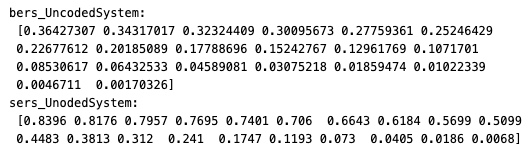 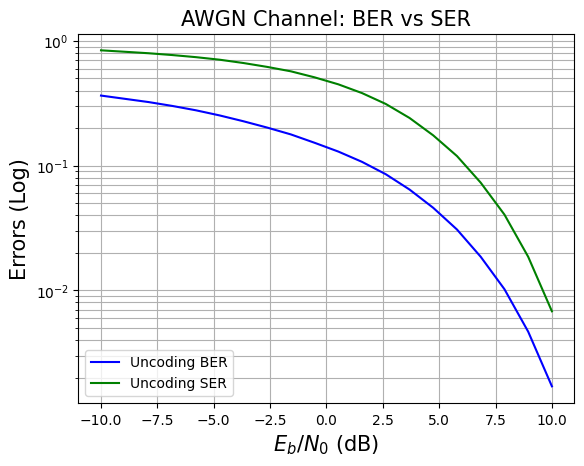

## LDPC Coding: BER vs SER

bers_UncodedSystem:
 [0.36261368 0.34448624 0.32322311 0.30134201 0.2790184  0.25235748
 0.2265625  0.20264435 0.17654419 0.15245056 0.12988281 0.10741806
 0.08478546 0.06456375 0.04586411 0.03085709 0.01852798 0.00971985
 0.00461197 0.00175095]
bers_CodedSystem:
 [0.42808533 0.41998291 0.40452194 0.39291763 0.37844086 0.36182404
 0.34274673 0.31933975 0.2965889  0.2701149  0.23692703 0.1952095
 0.12307358 0.01980591 0.0005455  0.         0.         0.
 0.         0.        ]
sers_UnodedSystem:
 [0.8372 0.8181 0.797  0.771  0.7431 0.7039 0.665  0.6196 0.567  0.5085
 0.4476 0.383  0.3102 0.2411 0.1748 0.1194 0.0727 0.0385 0.0184 0.007 ]
sers_CodedSystem:
 [0.8895 0.8825 0.8709 0.8597 0.8448 0.8289 0.8076 0.7787 0.7509 0.7126
 0.6607 0.5818 0.3918 0.0649 0.0019 0.     0.     0.     0.     0.    ]


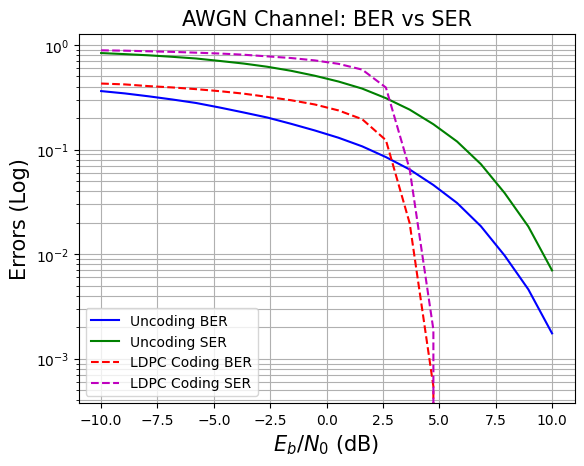

In [109]:
# Imports & Basics

# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

# For plotting
%matplotlib inline
# also try %matplotlib widget

import matplotlib.pyplot as plt

# for performance measurements
import time

# For the implementation of the Keras models
from tensorflow.keras import Model

from sionna.utils.misc import hard_decisions
from sionna.utils.metrics import compute_ber, compute_ser

CODERATE = 0.5
n = 512
k = int(n*CODERATE)

NUM_BITS_PER_SYMBOL = 4 # QPSK
BLOCK_LENGTH = k
BATCH_SIZE = 1024 # How many examples are processed by Sionna in parallel
EBN0_DB_MIN = -10.0 # Minimum value of Eb/N0 [dB] for simulations
EBN0_DB_MAX = 10.0 # Maximum value of Eb/N0 [dB] for simulations

# Constellation
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)
#constellation.show(figsize=(7,7));

# Mapper and Demapper
mapper = sn.mapping.Mapper(constellation=constellation)
# The demapper uses the same constellation object as the mapper
demapper = sn.mapping.Demapper("app", constellation=constellation)

# Binary source
binary_source = sn.utils.BinarySource()

# AWGN channel
awgn_channel = sn.channel.AWGN()

# LDPC Encoder
LDPC_encoder = sn.fec.ldpc.LDPC5GEncoder(k, n)

# LDPC Decoder
LDPC_decoder = sn.fec.ldpc.LDPC5GDecoder(LDPC_encoder, hard_out=True)

snrs = []
bers_UncodedSystem = []
sers_UncodedSystem = []
bers_CodedSystem = []
sers_CodedSystem = []

bits = binary_source([BATCH_SIZE,BLOCK_LENGTH])
# print('bits.shape =\n',bits.shape)
# print('bits = \n',bits)

Tx_Symbols = np.reshape(bits, (BATCH_SIZE, (BLOCK_LENGTH//NUM_BITS_PER_SYMBOL), NUM_BITS_PER_SYMBOL))
# print('Tx_Symbols.shape =\n',Tx_Symbols.shape)
# print('Tx_Symbols = \n',Tx_Symbols)

num_symbols = BATCH_SIZE*(BLOCK_LENGTH/NUM_BITS_PER_SYMBOL)
# print('num_symbols =\n',num_symbols)

for EBN0_DB in np.linspace(EBN0_DB_MIN,EBN0_DB_MAX,20):

    snrs += [EBN0_DB]

    no_UncodedSystem = sn.utils.ebnodb2no(ebno_db=EBN0_DB,
                            num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                            coderate=1.0) # Coderate set to 1 as we do uncoded transmission here

    no_CodedSystem = sn.utils.ebnodb2no(ebno_db=EBN0_DB,
                            num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                            coderate=CODERATE) # Coderate set to 1 as we do uncoded transmission here

    x_UncodedSystem = mapper(bits)

    y_UncodedSystem = awgn_channel([x_UncodedSystem, no_UncodedSystem])

    llr_UncodedSystem = demapper([y_UncodedSystem, no_UncodedSystem])

    bits_hat_UncodedSystem = hard_decisions(llr_UncodedSystem)

    Rx_Symbols_UncodedSystem = np.reshape(bits_hat_UncodedSystem, (BATCH_SIZE, (BLOCK_LENGTH//NUM_BITS_PER_SYMBOL), NUM_BITS_PER_SYMBOL)) # type: ignore
    # print('Rx_Symbols.shape =\n',Rx_Symbols_UncodedSystem.shape)
    # print('Rx_Symbols = \n',Rx_Symbols_UncodedSystem)

    ber_UncodedSystem = compute_ber(bits, bits_hat_UncodedSystem)

    error_array_UncodedSystem = np.all(Tx_Symbols == Rx_Symbols_UncodedSystem, axis=2)
    # print('compare =\n',compare)

    error_array_UncodedSystem_reshape = np.reshape(error_array_UncodedSystem, (BATCH_SIZE*(BLOCK_LENGTH//NUM_BITS_PER_SYMBOL), 1)) # type: ignore
    # print('compare_reshape =\n',compare_reshape)

    num_symbol_errors_UncodedSystem = np.count_nonzero(np.sum(~error_array_UncodedSystem_reshape, axis=1))
    # print('num_symbol_errors =\n',num_symbol_errors)

    ser_UncodedSystem = round(num_symbol_errors_UncodedSystem/num_symbols,4)
    # print('ser_UncodedSystem =\n',ser_UncodedSystem)
    # ser_UncodedSystem = compute_ser(Tx_Symbols, Rx_Symbols_UncodedSystem)

    bers_UncodedSystem += [ber_UncodedSystem]
    sers_UncodedSystem += [ser_UncodedSystem]


    codewords = LDPC_encoder(bits)

    x_CodedSystem = mapper(codewords)

    y_CodedSystem = awgn_channel([x_CodedSystem, no_CodedSystem])
        
    llr_CodedSystem = demapper([y_CodedSystem, no_CodedSystem])
        
    bits_hat_CodedSystem = LDPC_decoder(llr_CodedSystem)

    Rx_Symbols_CodedSystem = np.reshape(bits_hat_CodedSystem, (BATCH_SIZE, (BLOCK_LENGTH//NUM_BITS_PER_SYMBOL), NUM_BITS_PER_SYMBOL)) # type: ignore
            
    ber_CodedSystem = compute_ber(bits, bits_hat_CodedSystem)
            
    error_array_CodedSystem = np.all(Tx_Symbols == Rx_Symbols_CodedSystem, axis=2)
    # print('compare =\n',compare)

    error_array_CodedSystem_reshape = np.reshape(error_array_CodedSystem, (BATCH_SIZE*(BLOCK_LENGTH//NUM_BITS_PER_SYMBOL), 1)) # type: ignore
    # print('compare_reshape =\n',compare_reshape)

    num_symbol_errors_CodedSystem = np.count_nonzero(np.sum(~error_array_CodedSystem_reshape, axis=1))
    # print('num_symbol_errors =\n',num_symbol_errors)

    ser_CodedSystem = round(num_symbol_errors_CodedSystem/num_symbols,4)
    # print('ser_UncodedSystem =\n',ser_UncodedSystem)
    # ser_CodedSystem = compute_ser(Tx_Symbols, Rx_Symbols_CodedSystem)

    bers_CodedSystem += [ber_CodedSystem]
    sers_CodedSystem += [ser_CodedSystem]

print('bers_UncodedSystem:\n',np.transpose(bers_UncodedSystem))
print('bers_CodedSystem:\n',np.transpose(bers_CodedSystem))
print('sers_UnodedSystem:\n',np.transpose(sers_UncodedSystem))
print('sers_CodedSystem:\n',np.transpose(sers_CodedSystem))

title = "AWGN Channel: BER vs SER"
xlabel = "$E_b/N_0$ (dB)"
ylabel = "Errors (Log)"
plt.title(title, fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel(ylabel, fontsize=15)
plt.grid(which="both")
plt.semilogy(snrs, bers_UncodedSystem, 'b', label='Uncoding BER')
plt.semilogy(snrs, sers_UncodedSystem, 'g', label='Uncoding SER')
plt.semilogy(snrs, bers_CodedSystem, 'r--', label='LDPC Coding BER')
plt.semilogy(snrs, sers_CodedSystem, 'm--', label='LDPC Coding SER')
plt.legend(loc='lower left', fontsize=10)
plt.show()

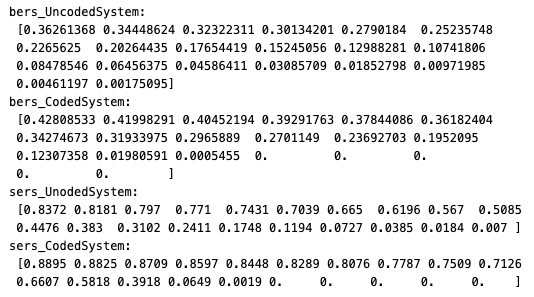 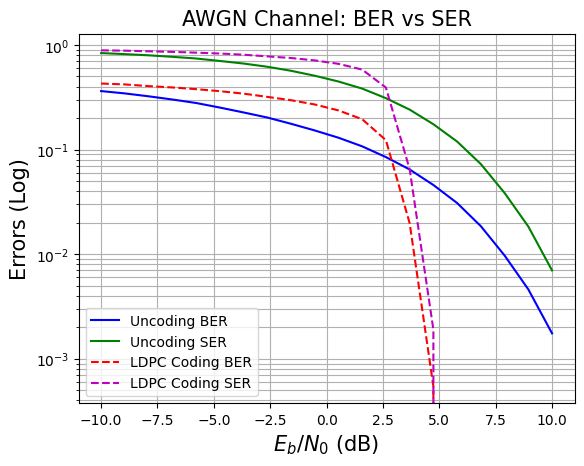

## (Unfinished) Linear Coding & LDPC Coding: BER vs SER

In [115]:
# Imports & Basics

# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

# For plotting
%matplotlib inline
# also try %matplotlib widget

import matplotlib.pyplot as plt

# for performance measurements
import time

# For the implementation of the Keras models
from tensorflow.keras import Model

from sionna.utils.misc import hard_decisions
from sionna.utils.metrics import compute_ber, compute_ser

CODERATE = 0.5
n = 512
k = int(n*CODERATE)

NUM_BITS_PER_SYMBOL = 4 # QPSK
BLOCK_LENGTH = k
BATCH_SIZE = 1024 # How many examples are processed by Sionna in parallel
EBN0_DB_MIN = -10.0 # Minimum value of Eb/N0 [dB] for simulations
EBN0_DB_MAX = 10.0 # Maximum value of Eb/N0 [dB] for simulations

# Constellation
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)
#constellation.show(figsize=(7,7));

# Mapper and Demapper
mapper = sn.mapping.Mapper(constellation=constellation)
# The demapper uses the same constellation object as the mapper
demapper = sn.mapping.Demapper("app", constellation=constellation)

# Binary source
binary_source = sn.utils.BinarySource()

# AWGN channel
awgn_channel = sn.channel.AWGN()

# Linear Encoder
Linear_encoder = sn.fec.LinearEncoder(rate=CODERATE, constraint_length=3) # type: ignore

# Linear Decoder
Linear_decoder = sn.fec.OSDecoder(Linear_encoder) # type: ignore

# LDPC Encoder
LDPC_encoder = sn.fec.ldpc.LDPC5GEncoder(k, n)

# LDPC Decoder
LDPC_decoder = sn.fec.ldpc.LDPC5GDecoder(LDPC_encoder, hard_out=True)

snrs = []
bers_UncodedSystem = []
sers_UncodedSystem = []
bers_CodedSystem = []
sers_CodedSystem = []
bers_LinearCodingSystem = []
sers_LinearCodingSystem = []

bits = binary_source([BATCH_SIZE,BLOCK_LENGTH])
# print('bits.shape =\n',bits.shape)
# print('bits = \n',bits)

Tx_Symbols = np.reshape(bits, (BATCH_SIZE, (BLOCK_LENGTH//NUM_BITS_PER_SYMBOL), NUM_BITS_PER_SYMBOL))
# print('Tx_Symbols.shape =\n',Tx_Symbols.shape)
# print('Tx_Symbols = \n',Tx_Symbols)

num_symbols = BATCH_SIZE*(BLOCK_LENGTH/NUM_BITS_PER_SYMBOL)
# print('num_symbols =\n',num_symbols)

for EBN0_DB in np.linspace(EBN0_DB_MIN,EBN0_DB_MAX,20):

    snrs += [EBN0_DB]

    no_UncodedSystem = sn.utils.ebnodb2no(ebno_db=EBN0_DB,
                            num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                            coderate=1.0) # Coderate set to 1 as we do uncoded transmission here

    no_CodedSystem = sn.utils.ebnodb2no(ebno_db=EBN0_DB,
                            num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                            coderate=CODERATE) # Coderate set to 1 as we do uncoded transmission here

    # x_UncodedSystem = mapper(bits)

    # y_UncodedSystem = awgn_channel([x_UncodedSystem, no_UncodedSystem])

    # llr_UncodedSystem = demapper([y_UncodedSystem, no_UncodedSystem])

    # bits_hat_UncodedSystem = hard_decisions(llr_UncodedSystem)

    # Rx_Symbols_UncodedSystem = np.reshape(bits_hat_UncodedSystem, (BATCH_SIZE, (BLOCK_LENGTH//NUM_BITS_PER_SYMBOL), NUM_BITS_PER_SYMBOL)) # type: ignore
    # # print('Rx_Symbols.shape =\n',Rx_Symbols_UncodedSystem.shape)
    # # print('Rx_Symbols = \n',Rx_Symbols_UncodedSystem)

    # ber_UncodedSystem = compute_ber(bits, bits_hat_UncodedSystem)

    # error_array_UncodedSystem = np.all(Tx_Symbols == Rx_Symbols_UncodedSystem, axis=2)
    # # print('compare =\n',compare)

    # error_array_UncodedSystem_reshape = np.reshape(error_array_UncodedSystem, (BATCH_SIZE*(BLOCK_LENGTH//NUM_BITS_PER_SYMBOL), 1)) # type: ignore
    # # print('compare_reshape =\n',compare_reshape)

    # num_symbol_errors_UncodedSystem = np.count_nonzero(np.sum(~error_array_UncodedSystem_reshape, axis=1))
    # # print('num_symbol_errors =\n',num_symbol_errors)

    # ser_UncodedSystem = round(num_symbol_errors_UncodedSystem/num_symbols,4)
    # # print('ser_UncodedSystem =\n',ser_UncodedSystem)
    # # ser_UncodedSystem = compute_ser(Tx_Symbols, Rx_Symbols_UncodedSystem)

    # bers_UncodedSystem += [ber_UncodedSystem]
    # sers_UncodedSystem += [ser_UncodedSystem]


    # codewords = LDPC_encoder(bits)

    # x_CodedSystem = mapper(codewords)

    # y_CodedSystem = awgn_channel([x_CodedSystem, no_CodedSystem])
        
    # llr_CodedSystem = demapper([y_CodedSystem, no_CodedSystem])
        
    # bits_hat_CodedSystem = LDPC_decoder(llr_CodedSystem)

    # Rx_Symbols_CodedSystem = np.reshape(bits_hat_CodedSystem, (BATCH_SIZE, (BLOCK_LENGTH//NUM_BITS_PER_SYMBOL), NUM_BITS_PER_SYMBOL)) # type: ignore
            
    # ber_CodedSystem = compute_ber(bits, bits_hat_CodedSystem)
            
    # error_array_CodedSystem = np.all(Tx_Symbols == Rx_Symbols_CodedSystem, axis=2)
    # # print('compare =\n',compare)

    # error_array_CodedSystem_reshape = np.reshape(error_array_CodedSystem, (BATCH_SIZE*(BLOCK_LENGTH//NUM_BITS_PER_SYMBOL), 1)) # type: ignore
    # # print('compare_reshape =\n',compare_reshape)

    # num_symbol_errors_CodedSystem = np.count_nonzero(np.sum(~error_array_CodedSystem_reshape, axis=1))
    # # print('num_symbol_errors =\n',num_symbol_errors)

    # ser_UncodedSystem = round(num_symbol_errors_CodedSystem/num_symbols,4)
    # # print('ser_UncodedSystem =\n',ser_UncodedSystem)
    # # ser_CodedSystem = compute_ser(Tx_Symbols, Rx_Symbols_CodedSystem)

    # bers_CodedSystem += [ber_CodedSystem]
    # sers_CodedSystem += [ser_CodedSystem]

    Linear_codewords = Linear_encoder(bits)

    x_LinearCodingSystem = mapper(Linear_codewords)

    y_LinearCodingSystem = awgn_channel([x_LinearCodingSystem, no_CodedSystem])
        
    llr_LinearCodingSystem = demapper([y_LinearCodingSystem, no_CodedSystem])
        
    bits_hat_LinearCodingSystem = LDPC_decoder(llr_LinearCodingSystem)

    Rx_Symbols_LinearCodingSystem = np.reshape(bits_hat_LinearCodingSystem, (BATCH_SIZE, (BLOCK_LENGTH//NUM_BITS_PER_SYMBOL), NUM_BITS_PER_SYMBOL)) # type: ignore
            
    ber_LinearCodingSystem = compute_ber(bits, bits_hat_LinearCodingSystem)
            
    error_array_LinearCodingSystem = np.all(Tx_Symbols == Rx_Symbols_LinearCodingSystem, axis=2)
    # print('compare =\n',compare)

    error_array_LinearCodingSystem_reshape = np.reshape(error_array_LinearCodingSystem, (BATCH_SIZE*(BLOCK_LENGTH//NUM_BITS_PER_SYMBOL), 1)) # type: ignore
    # print('compare_reshape =\n',compare_reshape)

    num_symbol_errors_LinearCodingSystem = np.count_nonzero(np.sum(~error_array_LinearCodingSystem_reshape, axis=1))
    # print('num_symbol_errors =\n',num_symbol_errors)

    ser_LinearCodingSystem = round(num_symbol_errors_LinearCodingSystem/num_symbols,4)
    # print('ser_UncodedSystem =\n',ser_UncodedSystem)
    # ser_CodedSystem = compute_ser(Tx_Symbols, Rx_Symbols_CodedSystem)

    bers_LinearCodingSystem += [ber_LinearCodingSystem]
    sers_LinearCodingSystem += [ser_LinearCodingSystem]

# print('bers_UncodedSystem:\n',np.transpose(bers_UncodedSystem))
# print('bers_CodedSystem:\n',np.transpose(bers_CodedSystem))
# print('sers_UnodedSystem:\n',np.transpose(sers_UncodedSystem))
# print('sers_CodedSystem:\n',np.transpose(sers_CodedSystem))
print('sers_UnodedSystem:\n',np.transpose(bers_LinearCodingSystem))
print('sers_CodedSystem:\n',np.transpose(sers_LinearCodingSystem))

title = "AWGN Channel: Uncoded vs Coded System"
xlabel = "$E_b/N_0$ (dB)"
ylabel = "Errors (Log)"
plt.title(title, fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel(ylabel, fontsize=15)
plt.grid(which="both")
# plt.semilogy(snrs, bers_UncodedSystem, 'b', label='Uncoded System BER')
# plt.semilogy(snrs, sers_UncodedSystem, 'g', label='Uncoded System SER')
# plt.semilogy(snrs, bers_CodedSystem, 'r--', label='Coded System BER')
# plt.semilogy(snrs, sers_CodedSystem, 'm--', label='Coded System SER')
plt.semilogy(snrs, bers_LinearCodingSystem, 'c.-', label='Linear Coding BER')
plt.semilogy(snrs, sers_LinearCodingSystem, 'y.-', label='Linear Coding SER')
plt.legend(loc='lower left', fontsize=10)
plt.show()

AttributeError: module 'sionna.fec' has no attribute 'LinearEncoder'

In [114]:
# Imports & Basics

# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

# For plotting
%matplotlib inline
# also try %matplotlib widget

import matplotlib.pyplot as plt

# for performance measurements
import time

# For the implementation of the Keras models
from tensorflow.keras import Model

from sionna.utils.misc import hard_decisions
from sionna.utils.metrics import compute_ber, compute_ser

CODERATE = 0.5
n = 512
k = int(n*CODERATE)

NUM_BITS_PER_SYMBOL = 4 # QPSK
BLOCK_LENGTH = k
BATCH_SIZE = 1024 # How many examples are processed by Sionna in parallel
EBN0_DB_MIN = -10.0 # Minimum value of Eb/N0 [dB] for simulations
EBN0_DB_MAX = 10.0 # Maximum value of Eb/N0 [dB] for simulations

# Constellation
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)
#constellation.show(figsize=(7,7));

# Mapper and Demapper
mapper = sn.mapping.Mapper(constellation=constellation)
# The demapper uses the same constellation object as the mapper
demapper = sn.mapping.Demapper("app", constellation=constellation)

# Binary source
binary_source = sn.utils.BinarySource()

# AWGN channel
awgn_channel = sn.channel.AWGN()

# Linear Encoder
Linear_encoder = sn.fec.LinearEncoder(rate=CODERATE, constraint_length=3) # type: ignore

# Linear Decoder
Linear_decoder = sn.fec.OSDecoder(Linear_encoder) # type: ignore

# LDPC Encoder
LDPC_encoder = sn.fec.ldpc.LDPC5GEncoder(k, n)

# LDPC Decoder
LDPC_decoder = sn.fec.ldpc.LDPC5GDecoder(LDPC_encoder, hard_out=True)

snrs = []
bers_UncodedSystem = []
sers_UncodedSystem = []
bers_CodedSystem = []
sers_CodedSystem = []

bits = binary_source([BATCH_SIZE,BLOCK_LENGTH])
# print('bits.shape =\n',bits.shape)
# print('bits = \n',bits)

Tx_Symbols = np.reshape(bits, (BATCH_SIZE, (BLOCK_LENGTH//NUM_BITS_PER_SYMBOL), NUM_BITS_PER_SYMBOL))
# print('Tx_Symbols.shape =\n',Tx_Symbols.shape)
# print('Tx_Symbols = \n',Tx_Symbols)

num_symbols = BATCH_SIZE*(BLOCK_LENGTH/NUM_BITS_PER_SYMBOL)
# print('num_symbols =\n',num_symbols)

for EBN0_DB in np.linspace(EBN0_DB_MIN,EBN0_DB_MAX,20):

    snrs += [EBN0_DB]

    no_UncodedSystem = sn.utils.ebnodb2no(ebno_db=EBN0_DB,
                            num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                            coderate=1.0) # Coderate set to 1 as we do uncoded transmission here

    no_CodedSystem = sn.utils.ebnodb2no(ebno_db=EBN0_DB,
                            num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                            coderate=CODERATE) # Coderate set to 1 as we do uncoded transmission here

    x_UncodedSystem = mapper(bits)

    y_UncodedSystem = awgn_channel([x_UncodedSystem, no_UncodedSystem])

    llr_UncodedSystem = demapper([y_UncodedSystem, no_UncodedSystem])

    bits_hat_UncodedSystem = hard_decisions(llr_UncodedSystem)

    Rx_Symbols_UncodedSystem = np.reshape(bits_hat_UncodedSystem, (BATCH_SIZE, (BLOCK_LENGTH//NUM_BITS_PER_SYMBOL), NUM_BITS_PER_SYMBOL)) # type: ignore
    # print('Rx_Symbols.shape =\n',Rx_Symbols_UncodedSystem.shape)
    # print('Rx_Symbols = \n',Rx_Symbols_UncodedSystem)

    ber_UncodedSystem = compute_ber(bits, bits_hat_UncodedSystem)

    error_array_UncodedSystem = np.all(Tx_Symbols == Rx_Symbols_UncodedSystem, axis=2)
    # print('compare =\n',compare)

    error_array_UncodedSystem_reshape = np.reshape(error_array_UncodedSystem, (BATCH_SIZE*(BLOCK_LENGTH//NUM_BITS_PER_SYMBOL), 1)) # type: ignore
    # print('compare_reshape =\n',compare_reshape)

    num_symbol_errors_UncodedSystem = np.count_nonzero(np.sum(~error_array_UncodedSystem_reshape, axis=1))
    # print('num_symbol_errors =\n',num_symbol_errors)

    ser_UncodedSystem = round(num_symbol_errors_UncodedSystem/num_symbols,4)
    # print('ser_UncodedSystem =\n',ser_UncodedSystem)
    # ser_UncodedSystem = compute_ser(Tx_Symbols, Rx_Symbols_UncodedSystem)

    bers_UncodedSystem += [ber_UncodedSystem]
    sers_UncodedSystem += [ser_UncodedSystem]


    codewords = LDPC_encoder(bits)

    x_CodedSystem = mapper(codewords)

    y_CodedSystem = awgn_channel([x_CodedSystem, no_CodedSystem])
        
    llr_CodedSystem = demapper([y_CodedSystem, no_CodedSystem])
        
    bits_hat_CodedSystem = LDPC_decoder(llr_CodedSystem)

    Rx_Symbols_CodedSystem = np.reshape(bits_hat_CodedSystem, (BATCH_SIZE, (BLOCK_LENGTH//NUM_BITS_PER_SYMBOL), NUM_BITS_PER_SYMBOL)) # type: ignore
            
    ber_CodedSystem = compute_ber(bits, bits_hat_CodedSystem)
            
    error_array_CodedSystem = np.all(Tx_Symbols == Rx_Symbols_CodedSystem, axis=2)
    # print('compare =\n',compare)

    error_array_CodedSystem_reshape = np.reshape(error_array_CodedSystem, (BATCH_SIZE*(BLOCK_LENGTH//NUM_BITS_PER_SYMBOL), 1)) # type: ignore
    # print('compare_reshape =\n',compare_reshape)

    num_symbol_errors_CodedSystem = np.count_nonzero(np.sum(~error_array_CodedSystem_reshape, axis=1))
    # print('num_symbol_errors =\n',num_symbol_errors)

    ser_UncodedSystem = round(num_symbol_errors_CodedSystem/num_symbols,4)
    # print('ser_UncodedSystem =\n',ser_UncodedSystem)
    # ser_CodedSystem = compute_ser(Tx_Symbols, Rx_Symbols_CodedSystem)

    bers_CodedSystem += [ber_CodedSystem]
    sers_CodedSystem += [ser_CodedSystem]

print('bers_UncodedSystem:\n',np.transpose(bers_UncodedSystem))
print('bers_CodedSystem:\n',np.transpose(bers_CodedSystem))
print('sers_UnodedSystem:\n',np.transpose(sers_UncodedSystem))
print('sers_CodedSystem:\n',np.transpose(sers_CodedSystem))

title = "AWGN Channel: Uncoded vs Coded System"
xlabel = "$E_b/N_0$ (dB)"
ylabel = "Errors (Log)"
plt.title(title, fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel(ylabel, fontsize=15)
plt.grid(which="both")
plt.semilogy(snrs, bers_UncodedSystem, 'b', label='Uncoded System BER')
plt.semilogy(snrs, sers_UncodedSystem, 'g', label='Uncoded System SER')
plt.semilogy(snrs, bers_CodedSystem, 'r--', label='Coded System BER')
plt.semilogy(snrs, sers_CodedSystem, 'm--', label='Coded System SER')
plt.legend(loc='lower left', fontsize=10)
plt.show()

AttributeError: module 'sionna.fec' has no attribute 'LinearEncoder'